In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
#imports
import os
import glob
import random
from scipy.io import loadmat
import numpy as np
import cv2

import keras
from keras.layers import (Input,Activation, Conv2D, Dropout, Convolution2D,UpSampling2D)
from keras.layers import (Activation, Conv3D, Dense, Dropout, Flatten,Conv2DTranspose,
                  Add,MaxPooling2D,MaxPooling3D, Input, Concatenate,BatchNormalization)
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import mean_absolute_error
from keras.models import Sequential,load_model,Model
from keras.optimizers import Adam
import os, math
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf


Using TensorFlow backend.


In [4]:
#data paths

driveroot="/content/gdrive/My Drive"

rgbdir="/content/gdrive/My Drive/NTIRE2020_Clean"
hsdir="/content/gdrive/My Drive/NTIRE2020"

hpath=hsdir+'/ARAD_HS_*.mat'
rpath_clean=rgbdir+'/ARAD_HS_*_clean.png'
# print(rgbdir,hsdir,hpath,rpath_clean)

num_samples=230#number of files to load

image_size=128

hlist=glob.glob(hpath)[0:num_samples]
rgblist=glob.glob(rpath_clean)[0:num_samples]
print("number of hyperspectral imgs:",len(hlist))
print("number of rgb images:",len(rgblist))

number of hyperspectral imgs: 230
number of rgb images: 230


In [0]:
#model params
epochs=5
batch_size=8
lr=0.0001

initial_epoch=0

model_save_dir="/content/gdrive/My Drive/Colab Notebooks/RGB2Hyperspectral group 45 cnn/models"
model_name="conv_autoencoder_normalised_pad_5"
version=1

In [6]:
def load_batch_hyper(filelist):
    final_numpyData=np.array(0)
    for i in range(len(filelist)):
        x=loadmat(filelist[i])
        matimg=x['cube']
        final_numpyData=matimg if i==0 else np.stack([final_numpyData,matimg]) if i==1 else np.concatenate([final_numpyData,np.expand_dims(matimg, axis=0)])
    return final_numpyData

y=load_batch_hyper(hlist[5:10])
y.shape

(5, 482, 512, 31)

In [7]:
def load_batch_rgb(filelist):
    final_numpyData=np.array(0)
    for i in range(len(filelist)):
        matimg = cv2.imread(filelist[i])
        final_numpyData=matimg if i==0 else np.stack([final_numpyData,matimg]) if i==1 else np.concatenate([final_numpyData,np.expand_dims(matimg, axis=0)])
    return final_numpyData
x=load_batch_rgb(rgblist[5:10])
x.shape

(5, 482, 512, 3)

In [0]:
from skimage import img_as_ubyte
def normalize_data(data):
	# print("Normalizing Data ...........................")
	# print(data.shape, data.dtype, "min:",data.min(), "max:",data.max())
	temp = img_as_ubyte(data)
	# print(temp.shape, temp.dtype, "min:",temp.min(), "max:",temp.max())
	data = temp/temp.max()
	# print(data.shape, data.dtype, "min:",data.min(), "max:",data.max())
	return data	

def resize_npFile(data, image_size, file_save_path=None, save=False):	
#   print("Resizing the input data .................",data.shape)
  resize_np = np.zeros((data.shape[0],image_size, image_size, data.shape[3]))

  for j in range(data.shape[0]):
    for i in range(data.shape[3]):			
      # cv2.imwrite('org.png',img_as_ubyte(data[j][:,:,i]))
      temp = cv2.resize(data[j][:,:,i],(image_size, image_size), interpolation=cv2.INTER_AREA)	
      resize_np[j][:,:,i] = temp
      # print(data[j].shape, data[j][:,:,i].shape, temp.shape, resize_np[j].shape)			
  if save == True:
    np.save(file_save_path, resize_np)
    print('Successfully Saved .....', file_save_path, resize_np.shape)	
  return resize_np

In [0]:
def imageLoader(files_x,files_y, batch_size):
    L = len(files_x)
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X = load_batch_rgb(files_x[batch_start:limit])
            Y = load_batch_hyper(files_y[batch_start:limit])

            #normalize
            X=normalize_data(X)
            Y=normalize_data(Y)

            #resize
            X=resize_npFile(X, image_size)
            Y=resize_npFile(Y, image_size)

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [0]:
#validation sets
Y_val=np.load(driveroot+"/Colab Notebooks/RGB2Hyperspectral group 45 cnn/validation sets/ntire2020_hs_validationset_10.npy")
X_val=np.load(driveroot+"/Colab Notebooks/RGB2Hyperspectral group 45 cnn/validation sets/ntire2020_rgbclean_validationset_10.npy")

In [11]:
#normalize
X_val=normalize_data(X_val)
Y_val=normalize_data(Y_val)

#resize
X_val=resize_npFile(X_val, image_size)
Y_val=resize_npFile(Y_val, image_size)

print("Validation set:",X_val.shape, Y_val.shape)

Validation set: (10, 128, 128, 3) (10, 128, 128, 31)


In [0]:
def old_rgb2hs(image_size):
	model = Sequential()
	model.add(Convolution2D(32, kernel_size=(3, 3),
	                        input_shape=(image_size,image_size,3), padding='same'))
	model.add(Activation('relu'))
	model.add(Convolution2D(64, kernel_size=(3, 3),padding='same'))
	model.add(Activation('relu'))
	# model.add(Dropout(0.25))
	model.add(Convolution2D(64, kernel_size=(3, 3),padding='same'))
	model.add(Activation('relu'))
	model.add(Convolution2D(64, kernel_size=(3, 3),padding='same'))
	model.add(Activation('relu'))
	# model.add(Dropout(0.25))

	model.add(Convolution2D(64, kernel_size=(3, 3),padding='same'))
	model.add(Activation('relu'))

	model.add(Conv2DTranspose(64,kernel_size=(3,3),padding='same'))
	model.add(Activation('relu'))
	model.add(Conv2DTranspose(64,kernel_size=(3,3),padding='same'))
	model.add(Activation('relu'))
	model.add(Conv2DTranspose(64,kernel_size=(3,3),padding='same'))
	model.add(Activation('relu'))
	model.add(Conv2DTranspose(64,kernel_size=(3,3),padding='same'))
	model.add(Activation('relu'))
	model.add(Conv2DTranspose(31,kernel_size=(3,3),padding='same'))
	model.add(Activation('relu'))

	return model


In [12]:
model=old_rgb2hs(image_size)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
activation_3 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 64)     

In [14]:
model.compile(loss='mean_absolute_error', optimizer=Adam(lr=lr), metrics=['mae','mse'])
checkpoint = keras.callbacks.ModelCheckpoint(model_save_dir+'/model_'+str(model_name)+'_'+str(version)+'_'+str(epochs)+'.h5',monitor='loss',verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=50)
csv_logger = keras.callbacks.CSVLogger(model_save_dir+ "/tr_-v"+str(version)+ str(model_name)+".csv", separator=',', append=True)

history=model.fit_generator(imageLoader(rgblist,hlist,batch_size), validation_data=(X_val, Y_val), steps_per_epoch=math.ceil(num_samples/batch_size), epochs=epochs,verbose=1,callbacks=[checkpoint, csv_logger], shuffle=True)
# history = model.fit(x=X_data, y=Y_data, batch_size=batch_size, epochs=epochs, verbose=1, initial_epoch=initial_epoch,
 					# validation_split=0.2,callbacks=[checkpoint, csv_logger], shuffle=False)
# history = model.fit(x=X_data, y=Y_data, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2, 
                            # validation_data=(X_val, Y_val), shuffle=True)

Epoch 1/5
20/29 [===================>..........] - ETA: 2:55 - loss: 0.1379 - mae: 0.1379 - mse: 0.0458

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


29/29 [==============================] - 602s 21s/step - loss: 0.1197 - mae: 0.1203 - mse: 0.0374 - val_loss: 0.1251 - val_mae: 0.1251 - val_mse: 0.0352
Epoch 2/5
29/29 [==============================] - 358s 12s/step - loss: 0.0679 - mae: 0.0682 - mse: 0.0152 - val_loss: 0.0826 - val_mae: 0.0826 - val_mse: 0.0183
Epoch 3/5
29/29 [==============================] - 350s 12s/step - loss: 0.0543 - mae: 0.0546 - mse: 0.0103 - val_loss: 0.0704 - val_mae: 0.0704 - val_mse: 0.0130
Epoch 4/5
29/29 [==============================] - 356s 12s/step - loss: 0.0473 - mae: 0.0475 - mse: 0.0078 - val_loss: 0.0632 - val_mae: 0.0632 - val_mse: 0.0107
Epoch 5/5
29/29 [==============================] - 358s 12s/step - loss: 0.0454 - mae: 0.0456 - mse: 0.0074 - val_loss: 0.0613 - val_mae: 0.0613 - val_mse: 0.0103


In [0]:
history.history

{'loss': [0.11847202376179074,
  0.07654866168032522,
  0.061519938885517746,
  0.05243055634200573,
  0.04919778515139352],
 'mae': [0.11847203, 0.076548666, 0.061519943, 0.05243056, 0.049197793],
 'mse': [0.036356695, 0.018499691, 0.013202109, 0.0099036135, 0.008824331],
 'val_loss': [0.13313300013542176,
  0.09582466185092926,
  0.07862676382064819,
  0.07130308002233506,
  0.0646667405962944],
 'val_mae': [0.13313300907611847,
  0.09582465887069702,
  0.07862676680088043,
  0.07130308449268341,
  0.0646667405962944],
 'val_mse': [0.03786646947264671,
  0.023361479863524437,
  0.015942687168717384,
  0.013495762832462788,
  0.011192454025149345]}

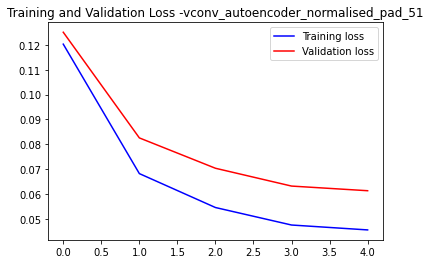

In [15]:
plt.plot(history.history['loss'], 'b', label='Training loss')
plt.plot(history.history['val_loss'], 'r', label='Validation loss')
plt.title('Training and Validation Loss -v'+str(model_name)+str(version))
plt.legend()
plt.savefig(os.path.join(model_save_dir, str(model_name)+'_train_loss_'+str(version)+'_'+str(epochs)+'.png')) 
# plt.show()

In [16]:
model_json = model.to_json()
with open(model_save_dir+'/model_'+str(model_name)+'_'+str(version)+'_'+str(epochs)+'.json', "w+") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(model_save_dir+'/model_'+str(model_name)+'_'+str(version)+'_'+str(epochs)+'.h5')
print("Saved model to disk")

Saved model to disk


In [17]:
sample_x,sample_y=X_val[0],Y_val[0]
y_pred=model.predict(np.expand_dims(sample_x,axis=0))
y_pred.shape

(1, 128, 128, 31)

In [0]:
sample_y.shape

(128, 128, 31)

In [18]:
rmaee=abs(sample_y-y_pred[0])/sample_y
rmaee.shape

(128, 128, 31)

In [19]:
rmaee

array([[[0.82718509, 1.        , 1.        , ..., 0.73942393,
         0.55634598, 0.62577598],
        [0.78117825, 1.        , 1.        , ..., 0.47605681,
         0.18058644, 0.4410791 ],
        [0.7599422 , 0.94295983, 0.96066842, ..., 0.22449883,
         0.19682307, 0.20899763],
        ...,
        [0.76726066, 0.88381928, 0.84488429, ..., 0.20141482,
         0.04584107, 0.04575903],
        [0.82933744, 0.83138367, 0.82338695, ..., 0.34444627,
         0.16604046, 0.26425551],
        [0.91653766, 0.78892685, 0.85628913, ..., 0.70090428,
         0.68070535, 0.47044967]],

       [[0.70068424, 0.98100358, 0.99508474, ..., 0.38252069,
         0.30362107, 0.14414682],
        [0.66377003, 0.85704528, 0.90842016, ..., 0.19547886,
         0.10732257, 0.21379727],
        [0.65501547, 0.62538252, 0.69651977, ..., 0.56717244,
         0.56234038, 0.62108158],
        ...,
        [0.73337589, 0.54948922, 0.63794224, ..., 0.43089554,
         0.35339134, 0.62288418],
        [0.8

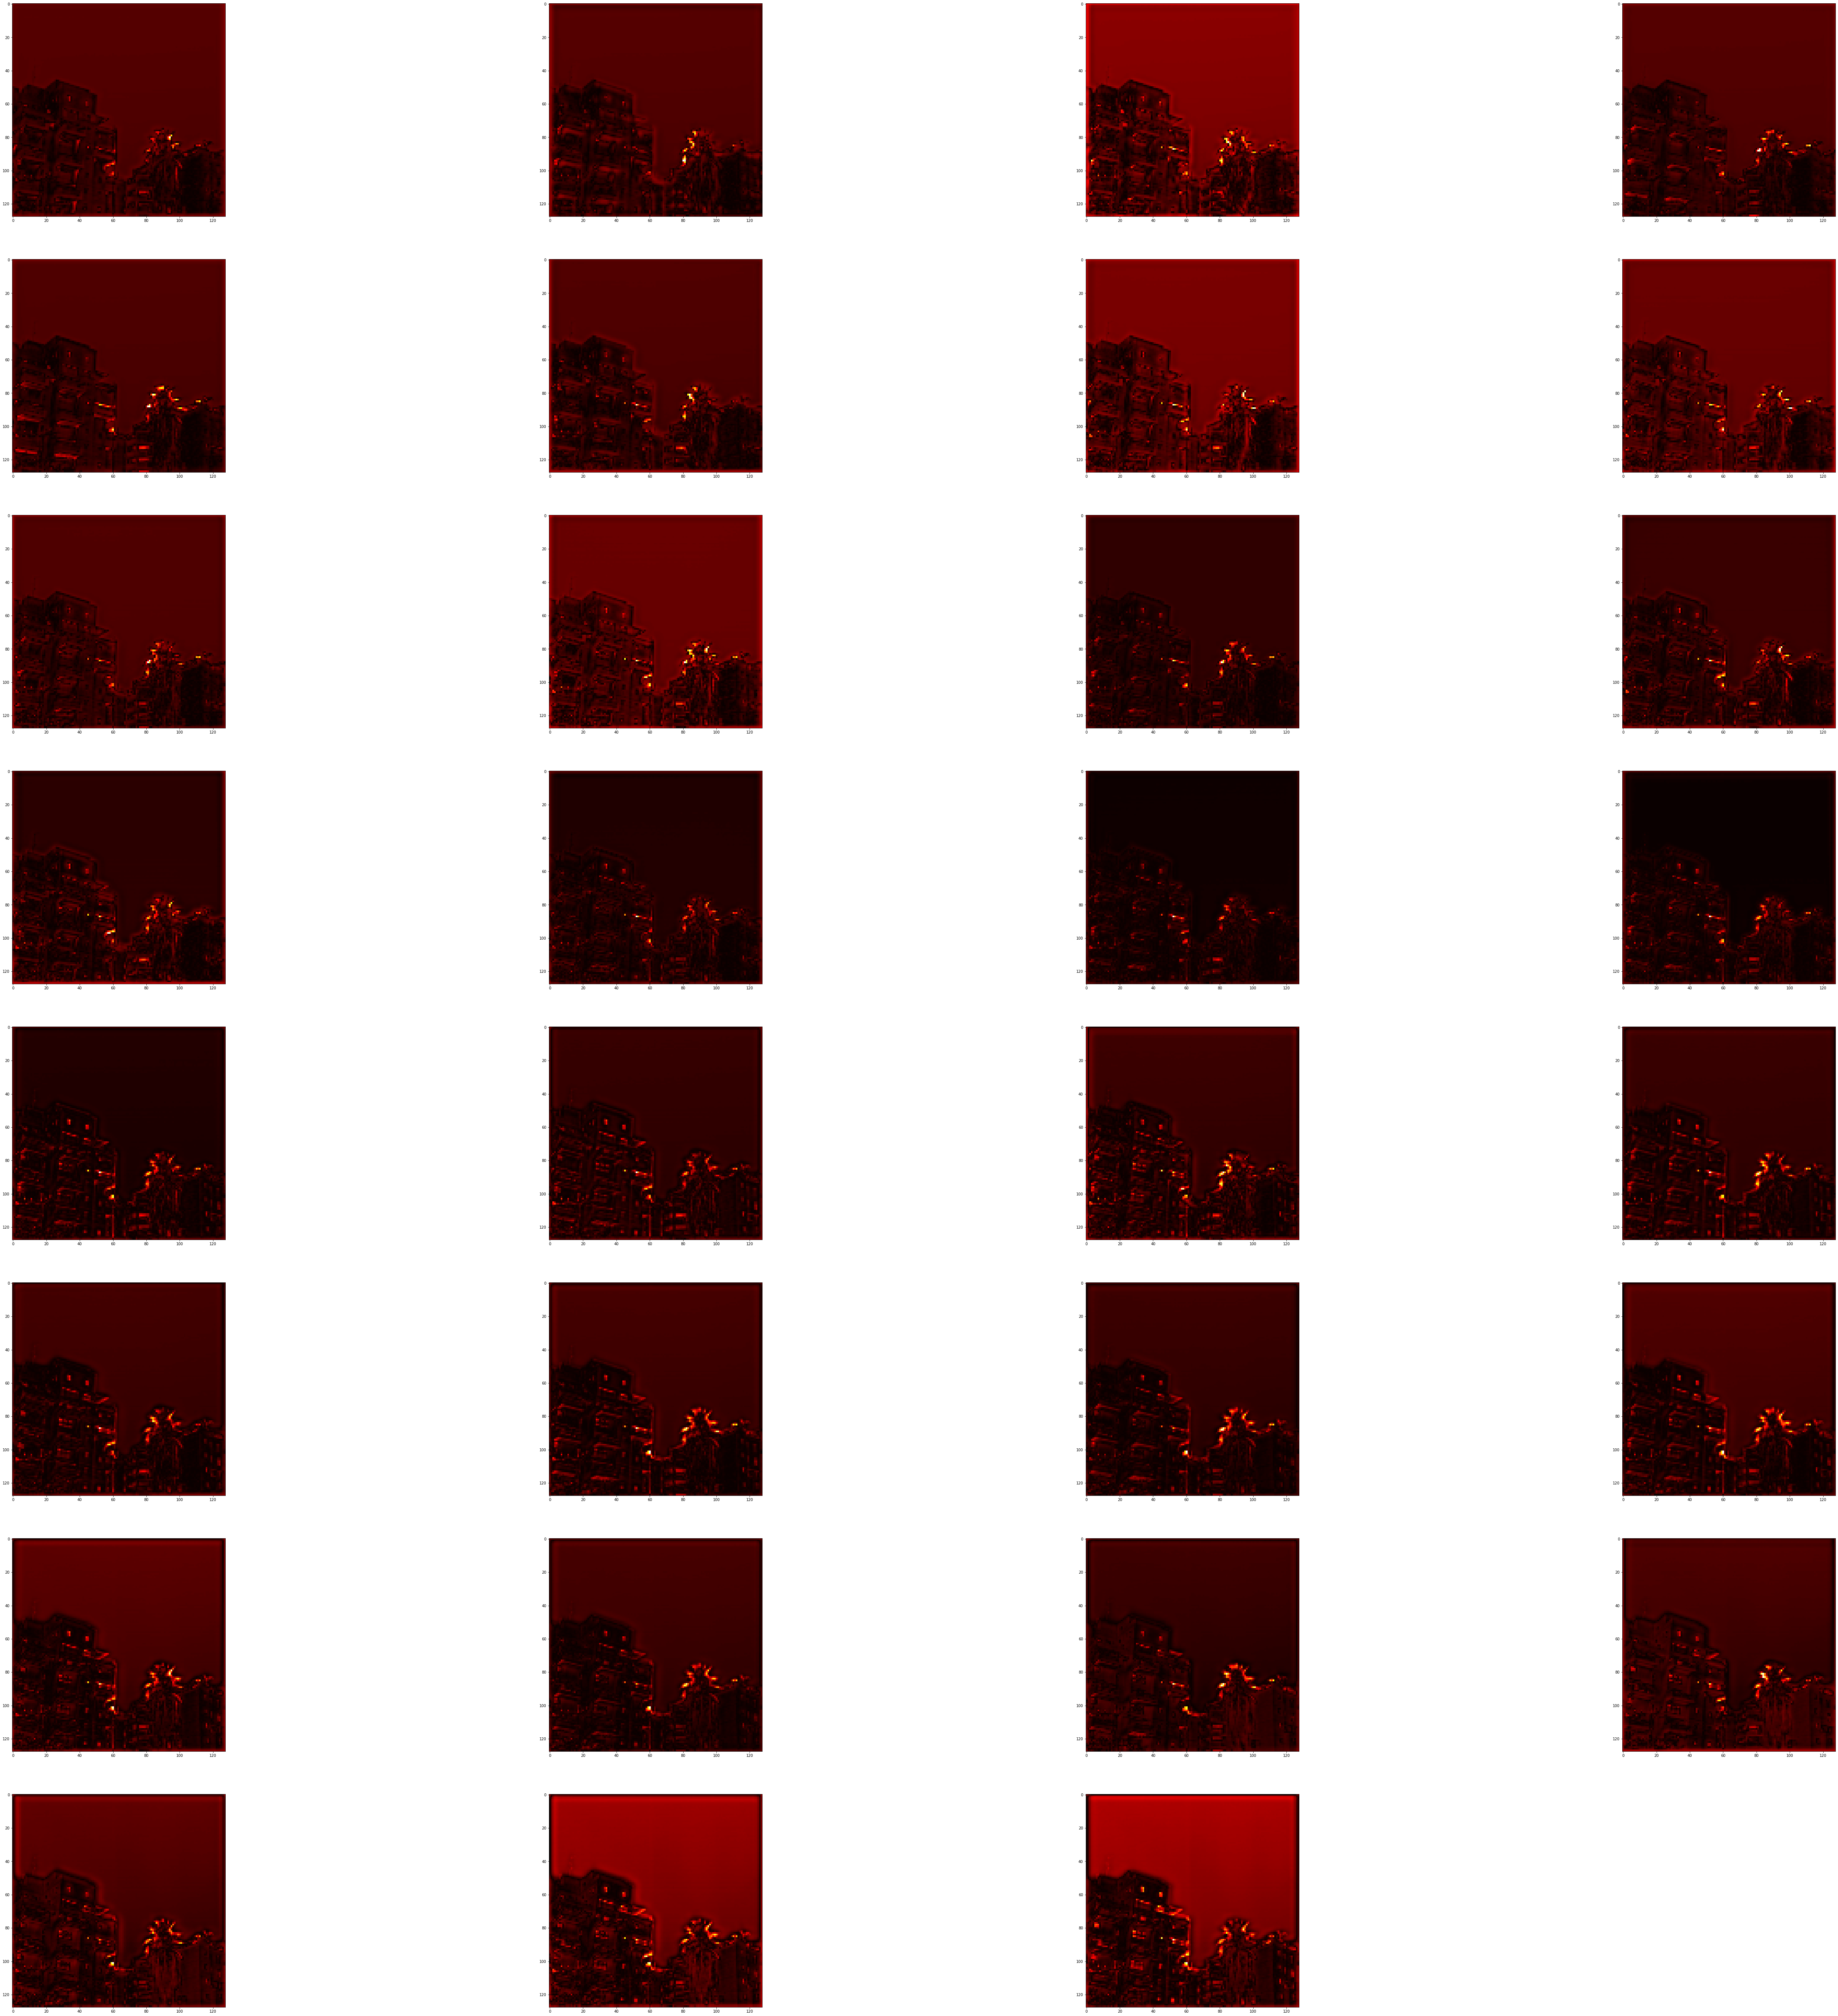

In [20]:
f=plt.figure(figsize=(100, 100))
for i in range(31):
    plt.subplot(8,4,i+1)
    plt.imshow(rmaee[:,:,i],cmap=plt.get_cmap('hot'), interpolation='nearest')
# plt.show()

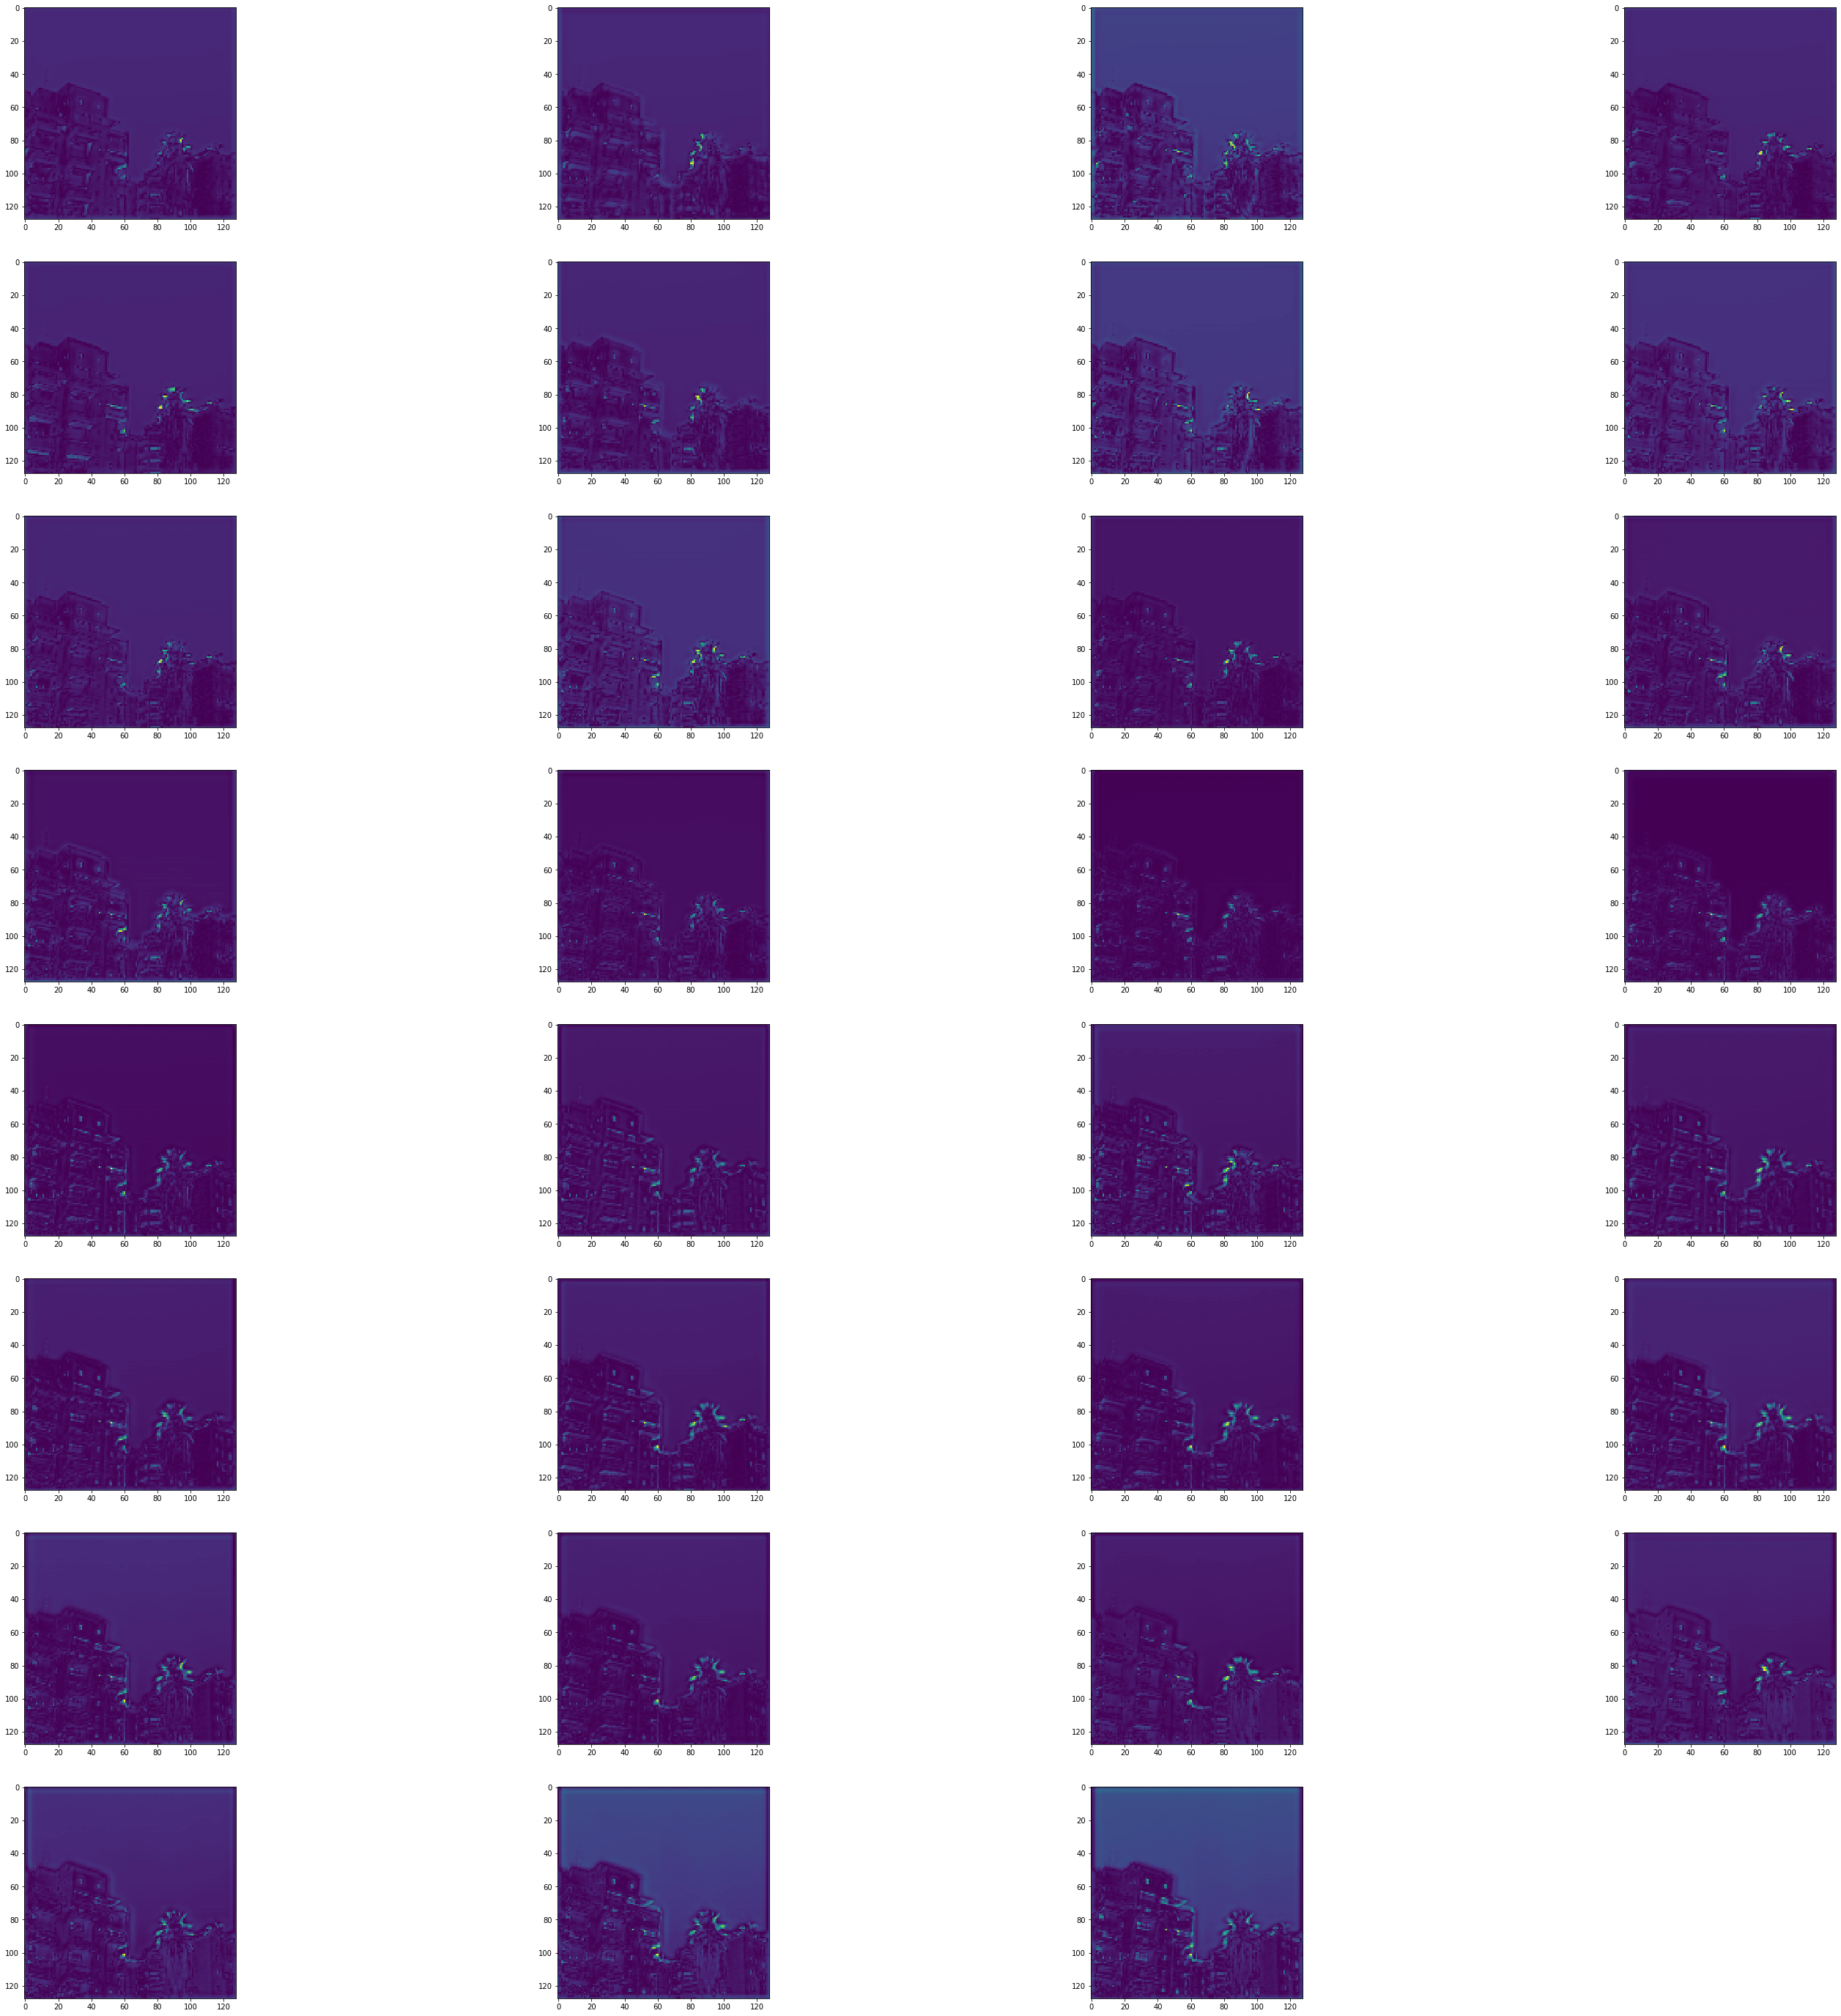

In [22]:
g=plt.figure(figsize=(50, 50))
for i in range(31):
    plt.subplot(8,4,i+1)
    plt.imshow(rmaee[:,:,i],cmap='viridis', interpolation='nearest')

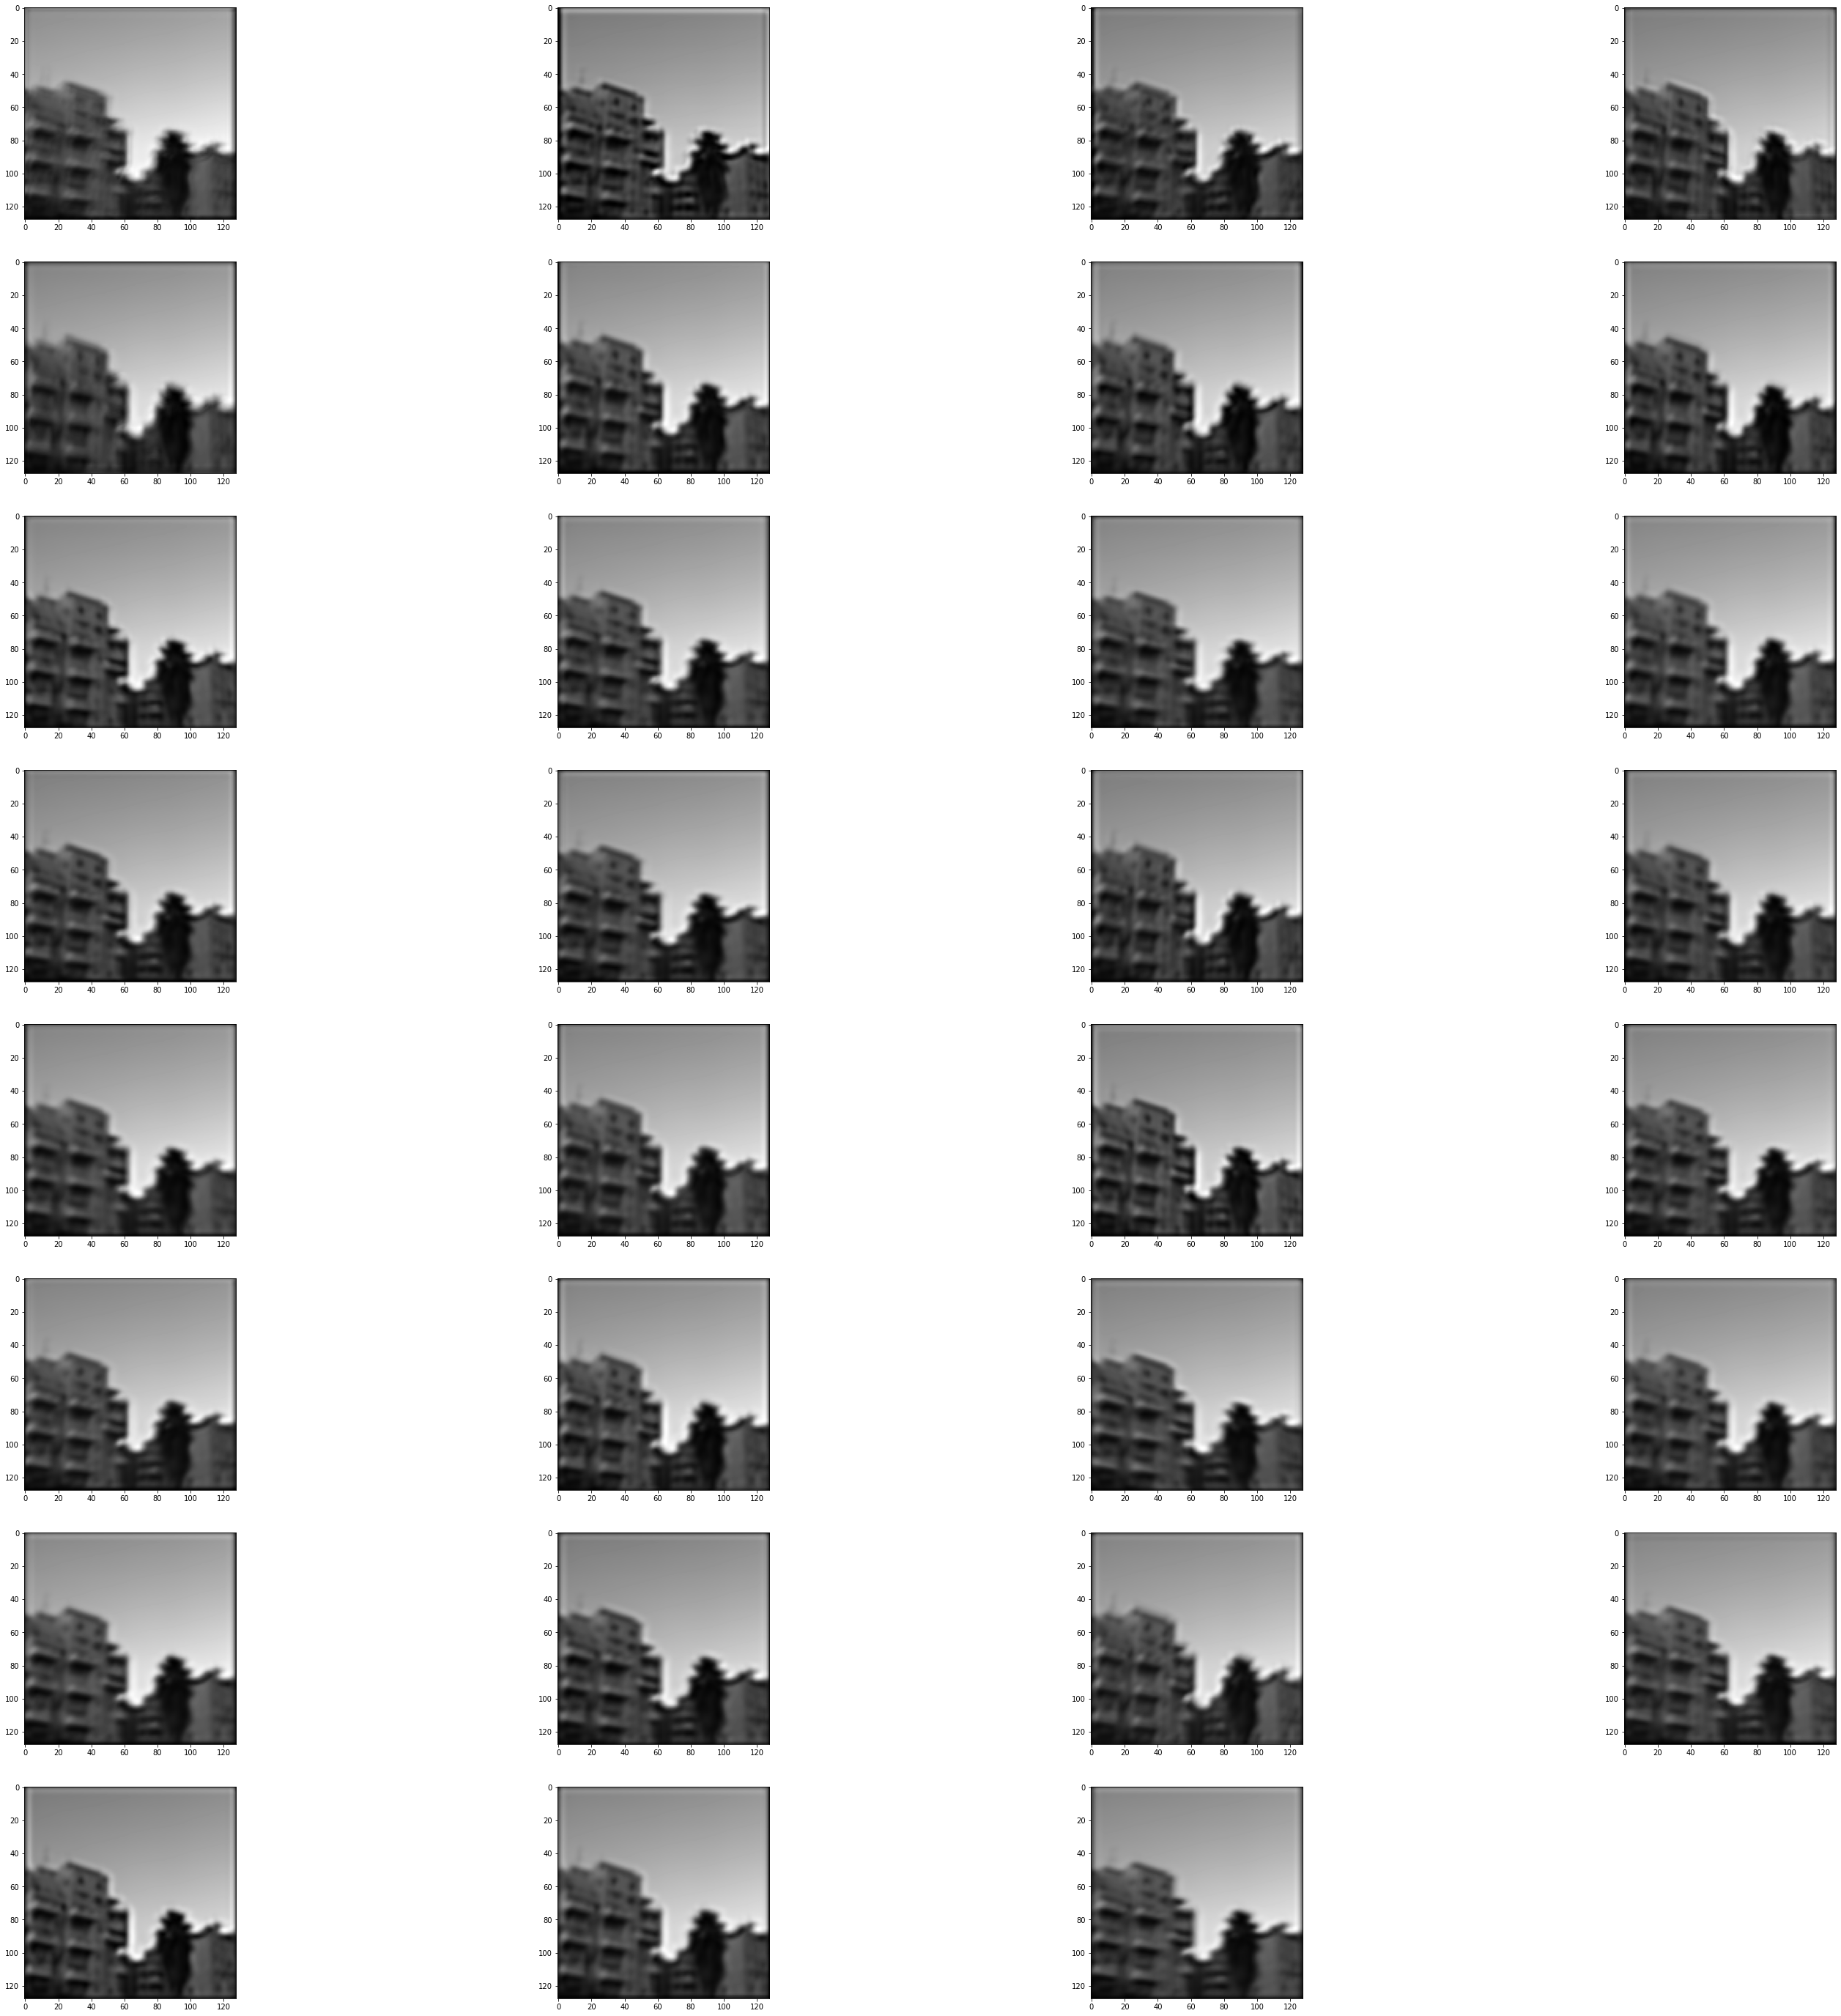

In [21]:
g=plt.figure(figsize=(50, 50))
for i in range(31):
    plt.subplot(8,4,i+1)
    plt.imshow(y_pred[0,:,:,i],cmap='gray')

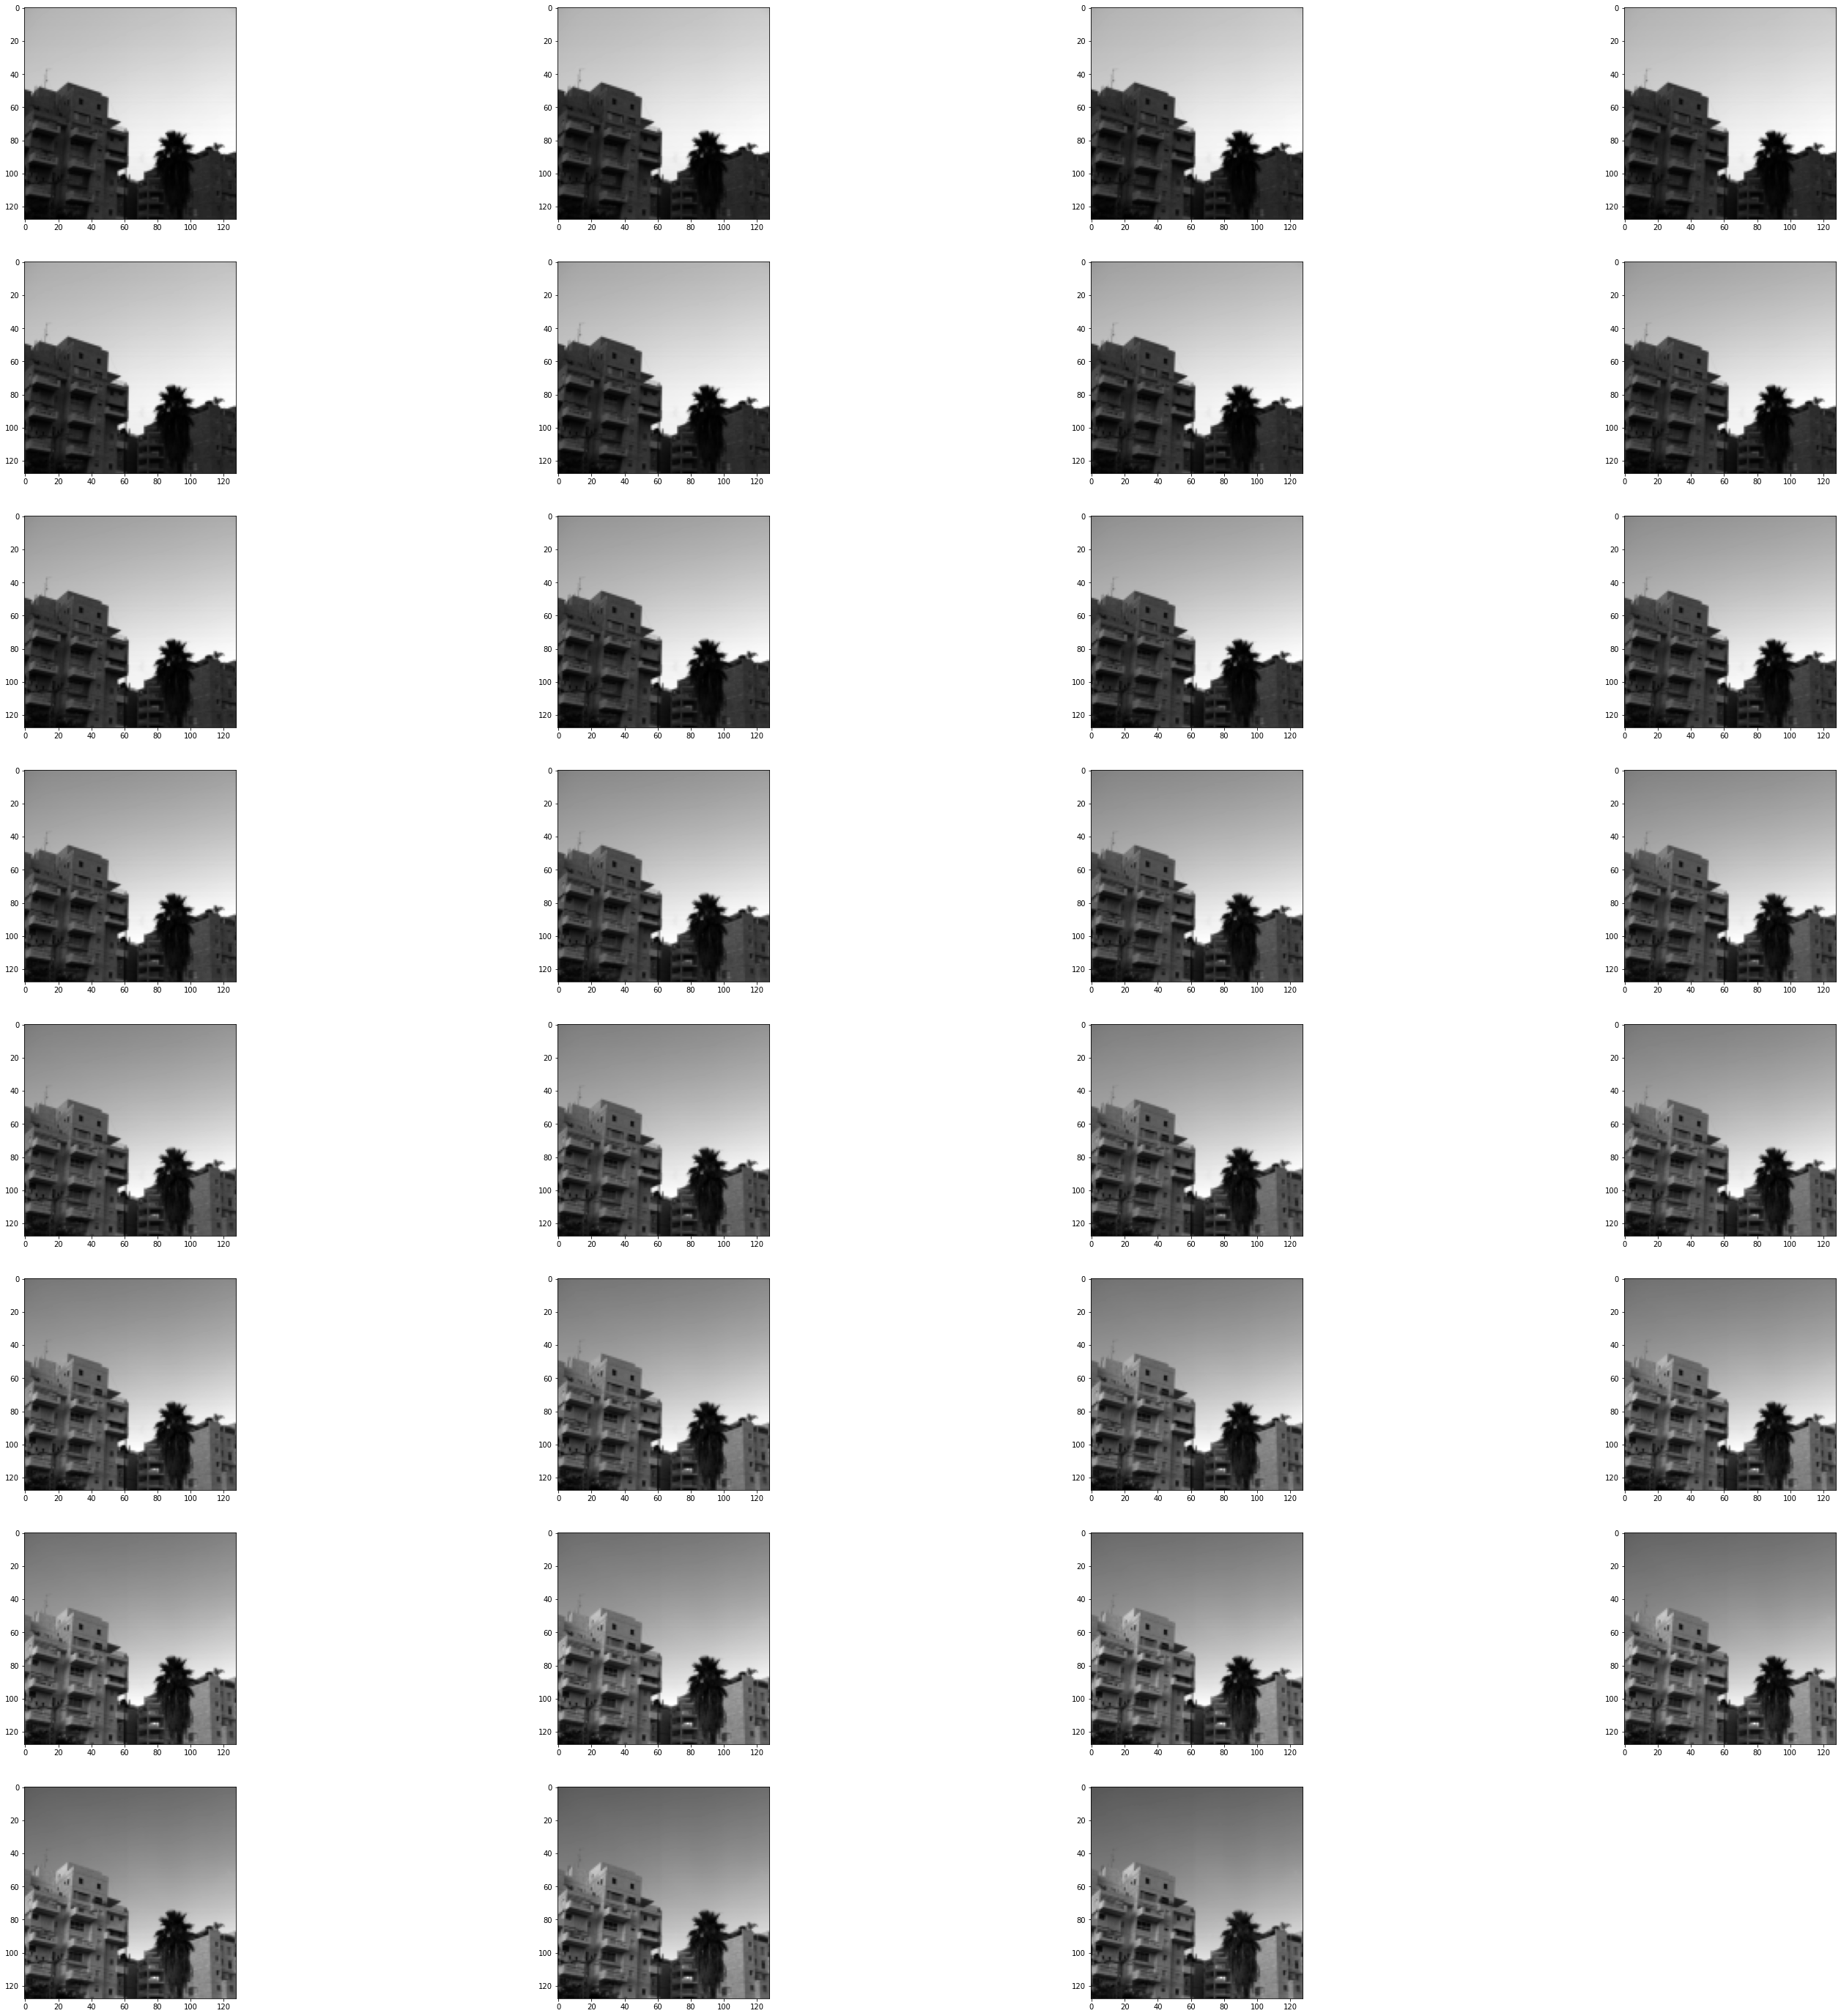

In [0]:
import matplotlib.pyplot as plt

g=plt.figure(figsize=(50, 50))
for i in range(31):
    plt.subplot(8,4,i+1)
    plt.imshow(sample_y[:,:,i],cmap='gray')

In [0]:
np.save(model_save_dir+"/abs_errs_"+str(model_name)+".npy", rmaee)